# ML Projet Part III (AirQuality)
**Jie ZHENG ** <br>
**Yunzhi BAI** <br>
<br>
<br>
<br>
**This part is for the real dataset: From March 2004 to February 2005 (one year) in a italien city,Ground Truth hourly averaged concentrations for CO in mg/m^3. **<br>
<br>
**To run this part, please run it "step by step"! In the sections of "Training", there are many models provided, please just run one chosen model at one time.** <br>
**For example: To use randomForest, just run the cells in the section "RandomForest". Then, do not run cells in other sections anymore!**
<br><br>
**IMPORTANT: There are other parts (for different datasets) in the directory.**

# 1. Preprocessing

## 1.1 Load Data

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=",")
df = df[["Date","Time","T","RH","AH","CO(GT)"]]
#df = pd.read_csv('train_27.csv', sep=';')

In [34]:
print df.shape
df.head()

(9471, 6)


,Date,Time,T,RH,AH,CO(GT)
0,10/03/2004,18.00.00,13.6,48.9,0.7578,2.6
1,10/03/2004,19.00.00,13.3,47.7,0.7255,2.0
2,10/03/2004,20.00.00,11.9,54.0,0.7502,2.2
3,10/03/2004,21.00.00,11.0,60.0,0.7867,2.2
4,10/03/2004,22.00.00,11.2,59.6,0.7888,1.6


## 1.2 Define functions and dictionaries

In [35]:
def deleteInvalidRecords(dataframe):
    df = dataframe.copy()
    df = df.dropna()
    indices = []
    for i in np.arange(len(df)):
        if df.ix[i]['CO(GT)']== -200.0:
            indices.append(i)
    df.drop(df.index[indices],inplace=True)
    return df.reset_index()

In [36]:
options_weekdays = {'Monday' : 1,
            'Tuesday' : 2,
            'Wednesday' : 3,
            'Thursday' : 4,
            'Friday' : 5,
            'Saturday' : 6,
            'Sunday' : 7,
}


options_weekend = {'Monday' : 0,
            'Tuesday' : 0,
            'Wednesday' : 0,
            'Thursday' : 0,
            'Friday' : 0,
            'Saturday' : 1,
            'Sunday' : 1,
}

options_weekdays_fr = {'Lundi' : 1,
            'Mardi' : 2,
            'Mercredi' : 3,
            'Jeudi' : 4,
            'Vendredi' : 5,
            'Samedi' : 6,
            'Dimanche' : 7,
}

nuit_jours = {'Nuit':0,'Jours':1}

In [37]:
import datetime

# to construct features about date
def gettime(dataframe):
    df = dataframe.copy()
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    n = len(df)
    for i in np.arange(n):
        tmp1 = df.ix[i].Date
        weekday = datetime.datetime.strptime(tmp1, '%d/%m/%Y').strftime('%A')
        tmp2 = df.ix[i].Time
        hour = '{d.hour}'.format(d=datetime.datetime.strptime(tmp2, '%H.%M.%S'))
        df.set_value(i, 'DAY_WE_DS', options_weekdays[weekday])
        df.set_value(i, 'WEEK_END', options_weekend[weekday])
        df.set_value(i, 'TPER_HOUR', hour)
        if (int(hour)>=8 and int(hour)<=22):
            df.set_value(i, 'TPER_TEAM', 1)
        else: df.set_value(i, 'TPER_TEAM', 0)
    return df
     
# 08:00:00.000 Jours 
# 22:00:00.000 Nuit

In [38]:
from pandas import DataFrame

def addMeanValues(df_train, byDAY_WE_DS=True, byDAY=True, byMonth=True, byHour=True, byTEAM=True, byYear=True):
    df = df_train.copy()
    if byDAY_WE_DS:
        df_meanByDAY_WE_DS = DataFrame({'meanByDAY_WE_DS':df.groupby(['DAY_WE_DS'])['CO(GT)'].mean()}).reset_index()
        df = df.join(df_meanByDAY_WE_DS.set_index('DAY_WE_DS'),on='DAY_WE_DS')
    if byDAY:
        df_meanByDAY = DataFrame({'meanByDay':df.groupby(['Day'])['CO(GT)'].mean()}).reset_index()
        df = df.join(df_meanByDAY.set_index('Day'),on='Day')
    if byMonth:
        df_meanByMONTH = DataFrame({'meanByMonth':df.groupby(['Month'])['CO(GT)'].mean()}).reset_index()
        df = df.join(df_meanByMONTH.set_index('Month'),on='Month')
    if byHour:
        df_meanByHour = DataFrame({'meanByHour':df.groupby(['TPER_HOUR'])['CO(GT)'].mean()}).reset_index()
        df = df.join(df_meanByHour.set_index('TPER_HOUR'),on='TPER_HOUR')
    if byTEAM:
        df_meanByTEAM = DataFrame({'meanByTEAM':df.groupby(['TPER_TEAM'])['CO(GT)'].mean()}).reset_index()
        df = df.join(df_meanByTEAM.set_index('TPER_TEAM'),on='TPER_TEAM')
    if byYear:
        df_meanByYear = DataFrame({'meanByYear':df.groupby(['Year'])['CO(GT)'].mean()}).reset_index()
        df = df.join(df_meanByYear.set_index('Year'),on='TPER_TEAM')   
    return df

## 1.3 Clean data and construct features about time for dataset

In [39]:
df_clean = deleteInvalidRecords(df)

print df_clean.shape
df_clean.head()

(7674, 7)


,index,Date,Time,T,RH,AH,CO(GT)
0,0,10/03/2004,18.00.00,13.6,48.9,0.7578,2.6
1,1,10/03/2004,19.00.00,13.3,47.7,0.7255,2.0
2,2,10/03/2004,20.00.00,11.9,54.0,0.7502,2.2
3,3,10/03/2004,21.00.00,11.0,60.0,0.7867,2.2
4,4,10/03/2004,22.00.00,11.2,59.6,0.7888,1.6


In [40]:
df_v0 = gettime(df_clean)
df_v0.head(5)

,index,Date,Time,T,RH,AH,CO(GT),Year,Month,Day,DAY_WE_DS,WEEK_END,TPER_HOUR,TPER_TEAM
0,0,10/03/2004,18.00.00,13.6,48.9,0.7578,2.6,2004,10,3,3,0,18,1
1,1,10/03/2004,19.00.00,13.3,47.7,0.7255,2.0,2004,10,3,3,0,19,1
2,2,10/03/2004,20.00.00,11.9,54.0,0.7502,2.2,2004,10,3,3,0,20,1
3,3,10/03/2004,21.00.00,11.0,60.0,0.7867,2.2,2004,10,3,3,0,21,1
4,4,10/03/2004,22.00.00,11.2,59.6,0.7888,1.6,2004,10,3,3,0,22,1


## 1.4 Add statistic information (average received calls), use OneHotEncoder

In [41]:
listToEncoder = ['DAY_WE_DS','TPER_HOUR']

df_v1 = addMeanValues(df_v0, byDAY_WE_DS=True, byDAY=True, byMonth=True, byHour=True, byTEAM=True, byYear=False)
df_v1 = df_v1[['T','RH','AH','CO(GT)','WEEK_END','DAY_WE_DS','TPER_TEAM','TPER_HOUR','Year','Month','Day','meanByDAY_WE_DS','meanByDay','meanByMonth','meanByHour','meanByTEAM']]
df_v1 = pd.get_dummies(df_v1,columns=listToEncoder)

df_v1.head()

,T,RH,AH,CO(GT),WEEK_END,TPER_TEAM,Year,Month,Day,meanByDAY_WE_DS,...,TPER_HOUR_21,TPER_HOUR_22,TPER_HOUR_23,TPER_HOUR_3,TPER_HOUR_4,TPER_HOUR_5,TPER_HOUR_6,TPER_HOUR_7,TPER_HOUR_8,TPER_HOUR_9
0,13.6,48.9,0.7578,2.6,0,1,2004,10,3,2.400787,...,0,0,0,0,0,0,0,0,0,0
1,13.3,47.7,0.7255,2.0,0,1,2004,10,3,2.400787,...,0,0,0,0,0,0,0,0,0,0
2,11.9,54.0,0.7502,2.2,0,1,2004,10,3,2.400787,...,0,0,0,0,0,0,0,0,0,0
3,11.0,60.0,0.7867,2.2,0,1,2004,10,3,2.400787,...,1,0,0,0,0,0,0,0,0,0
4,11.2,59.6,0.7888,1.6,0,1,2004,10,3,2.400787,...,0,1,0,0,0,0,0,0,0,0


# 2. Training

## 2.1 RandomForest

In [42]:
y = df_v1['CO(GT)'].values
X = df_v1.drop('CO(GT)',axis=1).values

In [43]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)   
randomForest.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [44]:
y_pred = randomForest.predict(X)

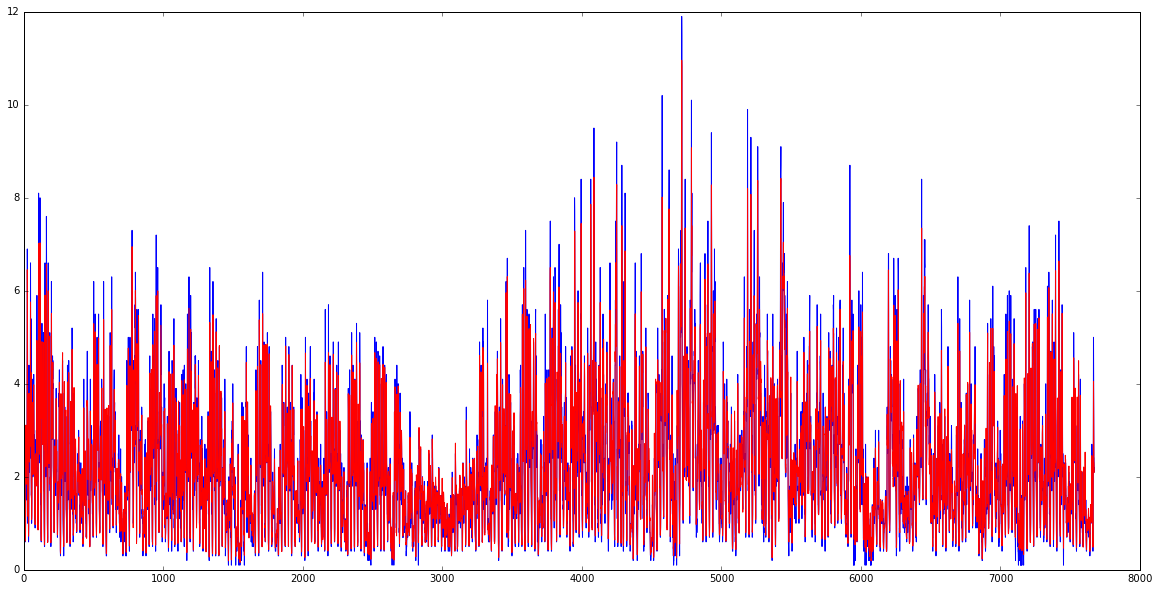

In [45]:
plt.figure(figsize=(20,10))
plt.plot(y)
plt.plot(y_pred,'r')
plt.show()

In [46]:
print "RMSE: "+ str(np.sqrt(sum((y_pred-y)**2)/len(y)))

RMSE: 0.268247016422


## 2.2 Time Series

### 2.2.1 Load and transform data

In [47]:
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=",")
df = df[["Date","Time","CO(GT)"]]

In [48]:
df_clean = deleteInvalidRecords(df)[["Date","Time","CO(GT)"]]
df_clean.head()

,Date,Time,CO(GT)
0,10/03/2004,18.00.00,2.6
1,10/03/2004,19.00.00,2.0
2,10/03/2004,20.00.00,2.2
3,10/03/2004,21.00.00,2.2
4,10/03/2004,22.00.00,1.6


In [49]:
def transform1(dataframe):
    df = dataframe.copy()
    df['DATE'] = df['Date']+':'+df['Time']
    n = len(df)
    for i in np.arange(n):
        tmp1 = df.ix[i].DATE
        tmp2 = pd.datetime.strptime(tmp1, '%d/%m/%Y:%H.%M.%S')
        df.set_value(i, 'DATE', tmp2)
    return df[["DATE",'CO(GT)']].set_index('DATE')

In [50]:
df_v1 = transform1(df_clean)
df_v1.head()

,CO(GT)
DATE,
2004-03-10 18:00:00,2.6
2004-03-10 19:00:00,2.0
2004-03-10 20:00:00,2.2
2004-03-10 21:00:00,2.2
2004-03-10 22:00:00,1.6


In [51]:
ts = df_v1['CO(GT)']

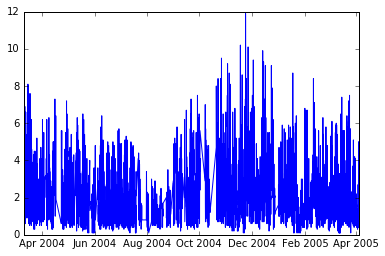

In [52]:
plt.plot(ts)

### 2.2.2 Test the stationarity

In [53]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=720)
    rolstd = pd.rolling_std(timeseries, window=720)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

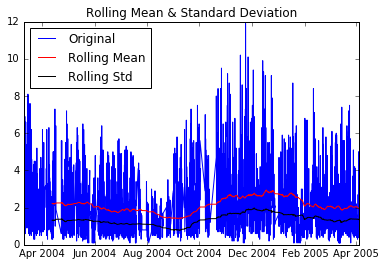

Results of Dickey-Fuller Test:
Test Statistic                -9.556031e+00
p-value                        2.497592e-16
#Lags Used                     3.600000e+01
Number of Observations Used    7.637000e+03
Critical Value (5%)           -2.861919e+00
Critical Value (1%)           -3.431207e+00
Critical Value (10%)          -2.566971e+00
dtype: float64


In [54]:
test_stationarity(ts)

### 2.2.3 Determiner the parametors for ARIMA

In [55]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts, nlags=24)
lag_pacf = pacf(ts, nlags=24, method='ols')

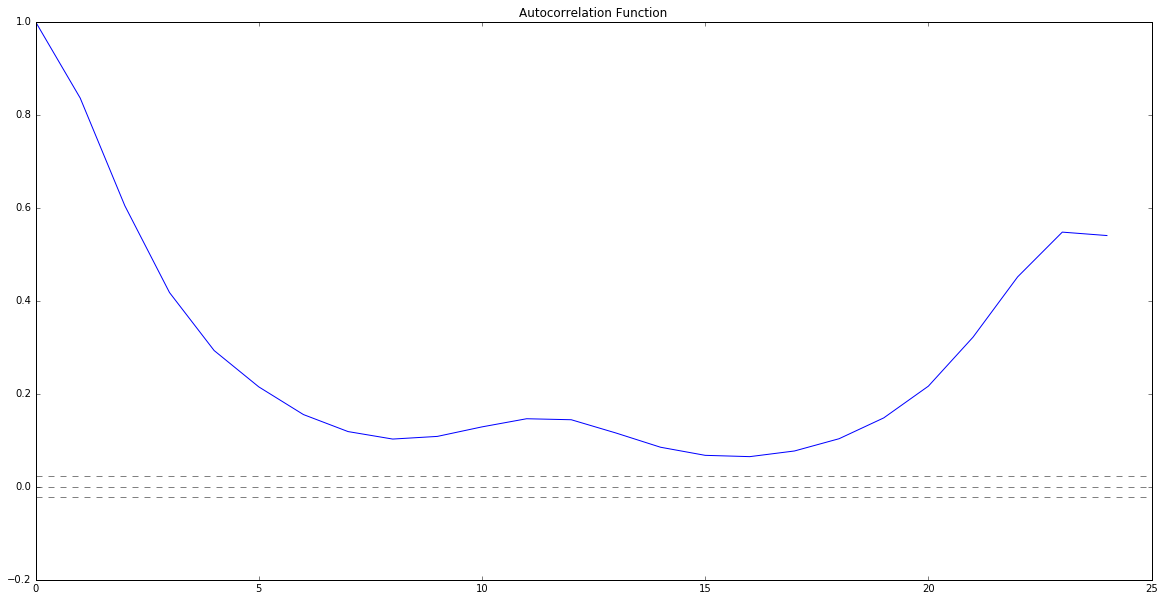

In [56]:
#Plot ACF: 
plt.figure(figsize=(20,10))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

**Note that here we cant get the value of q, so we assume that q=1 (comfirmed by testing different value in training)**

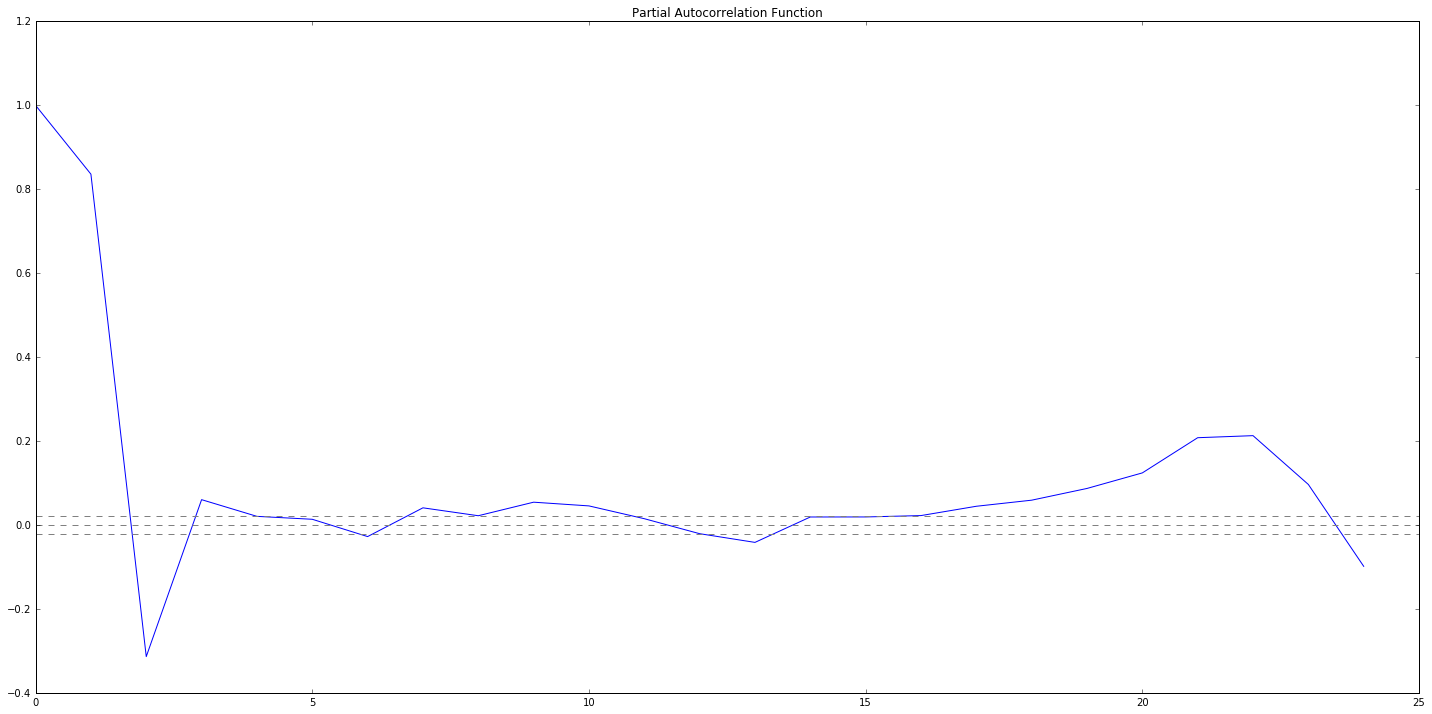

In [57]:
#Plot PACF:
plt.figure(figsize=(20,10))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**P=2**

### 2.2.4 Train ARIMA model

**param = (p, d, q)**

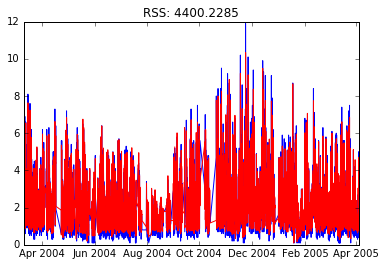

In [58]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts)**2))

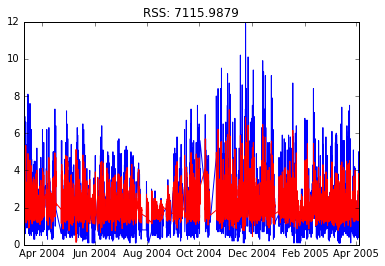

In [59]:
model = ARIMA(ts, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts)**2))

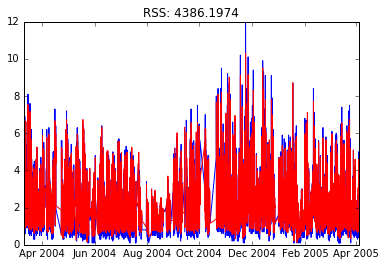

In [60]:
model = ARIMA(ts, order=(2, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

In [61]:
print "RMSE: "+ str(np.sqrt(sum((results_ARIMA.fittedvalues-ts)**2)/len(ts)))

RMSE: 0.756019831761
